In [116]:
import matplotlib.pyplot as plt
import glob
import os
import json
import numpy as np
import pandas as pd
from utils import load_m4_data, load_m3_data, DeTrendSeason
from transformation import Transformation

plt.rcParams["figure.figsize"] = (21, 10)
plt.rcParams["font.size"] = 24
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["legend.handlelength"] = 2

In [117]:
# datasets = load_m4_data(min_length=1000, max_length=1500, n_set=64, freq='Daily')
# for name, series in datasets.items():
#     plt.plot(series)
#     plt.title(name)
#     plt.show()

In [118]:
df = pd.read_excel('./Dataset/M3c.xls', sheet_name='M3Month')
df.set_index(['Series'], inplace=True)
cate = pd.DataFrame(df.loc[:, 'Category'])

In [119]:
bad = ['D173', 'D50', 'D56', 'D86', 'D48', 'D49']
bad = []

def load_json(base_dir='./json_data', target_file=None):
    datas = []
    if not target_file:
        filepath = '/'.join([base_dir, '*.json'])
        target_file = max(glob.glob(filepath), key = os.path.getctime)
    print(target_file)
    with open(target_file, 'r') as file:
        for line in file.readlines():
            data = json.loads(line)
            if data['name'] in bad:
                continue
            datas.append(data)

    return datas

In [120]:
# datas = load_json(target_file='./json_data/m3_96_series.json')
# datas = load_json(target_file='./json_data/m3_48_log.json')
# datas = load_json(target_file='./json_data/m4_55_log_tmp.json')

# datas = load_json(target_file='./json_data/results_1657795470.json') ## m3 print log return prediction
# datas = load_json(target_file='./json_data/total_m3.json')
# datas = load_json(target_file='./json_data/test_gru_naive.json')
# datas = load_json(target_file='./json_data/m3_100_log.json')
# datas = load_json(target_file='./json_data/test_m3.json')
# datas = load_json(target_file='./json_data/m3_1043_detrend_v1_0722.json')
# datas = load_json(target_file='./json_data/m3_1043_origin_v1_0724.json')
datas = load_json(target_file='./json_data/results_1658846714.json')

./json_data/results_1658846714.json


In [121]:
from utils import Performance_metrics
p = Performance_metrics()

count = 0
for data in datas:
    # if data['name'] != 'N1679':
    #     continue
    test = np.array(data['test_y']).ravel()
    for key in ['untransformed', 'transformed']:
        for model_name, model_val in data[key].items():
            # s = p.one_measure(scoring='symmetric_mean_absolute_percentage_error', true_y=test, pred_y=model_val['prediction'])
            # print(f'{model_name} {key}: {s}')
            if model_name == 'RandomForestRegressor':
                if data['untransformed'][model_name]['additional_info']['fitted_params']['n_estimators'] == 10:
                    count += 1
            else:
                continue
            # print(model_name, data['untransformed'][model_name]['additional_info']['fitted_params'])
    break

# from utils import Performance_metrics

# for data in datas:

#     test = np.array(data['test_y']).ravel()
#     for key in ['untransformed', 'transformed']:
#         for model_name, model_val in data[key].items():
#             print(f'{model_name} {key}')
#             p = Performance_metrics(true_y=test, predict_y=model_val['prediction'])
#             p.measuring(model_name=model_name, dataset_name=data['name'])
#             print('=='*20)
    

In [122]:
def plot_prediction(datas, model, dataset_name='', n_dataset=1, only_test=True):
    t = Transformation(datas)
    n_dataset_list = set()
    base = True
    df = pd.DataFrame()

    for data in datas:

        if model not in data['untransformed']:
            return

        if dataset_name and data['name'] != dataset_name:
            continue
        if len(n_dataset_list) < n_dataset:
            n_dataset_list.add(data['name'])
        if data['name'] not in n_dataset_list:
            continue

        train = np.array(data['train_y']).ravel()
        test = np.array(data['test_y']).ravel()

        if only_test:
            test_time_idx = range(len(test))
        else:
            train_time_idx = range(len(train)+len(test))[:len(train)]
            test_time_idx = range(len(train)+len(test))[len(train):]

        if base:
            if not only_test:
                plt.plot(train_time_idx, train, linewidth=8, alpha=0.5, label='train data')
                plt.plot(train_time_idx, t.dwt(train, wavelet=data['transformed'][model]['threshold']), linewidth=8, alpha=0.5, label='train data (trans)')
            plt.plot(test_time_idx, test, label='test data', linewidth=8, alpha=0.5)
            plt.title(f'Series: {data["name"]}, Model: {model}')
            plt.legend()
            base = False

        pred = data['untransformed'][model]['prediction']
        label = f"untransformed series, Lag: {data['untransformed'][model]['lags']}, SMAPE: {data['untransformed'][model]['symmetric_mean_absolute_percentage_error']}, RMSE: {data['untransformed'][model]['root_mean_squared_error']}"
        plt.plot(test_time_idx, pred, label=label, linewidth=5, alpha=0.5)
        
        pred = data['transformed'][model]['prediction']
        label = f"threshold: {data['transformed'][model]['threshold']}, Lag: {data['transformed'][model]['lags']}, SMAPE: {data['transformed'][model]['symmetric_mean_absolute_percentage_error']}, RMSE: {data['transformed'][model]['root_mean_squared_error']}"
        plt.plot(test_time_idx, pred, label=label, linewidth=2.5, alpha=0.8)
        
        plt.legend()

    plt.tight_layout()
    plt.show()

In [123]:
def plot_log_prediction(datas, model, dataset_name='', n_dataset=1, only_test=True):
        n_dataset_list = set()
        base = True
        df = pd.DataFrame()

        for data in datas:
            if 'logr_train_y' not in data:
                return

            if model not in data['untransformed']:
                return

            if dataset_name and data['name'] != dataset_name:
                continue
            if len(n_dataset_list) < n_dataset:
                n_dataset_list.add(data['name'])
            if data['name'] not in n_dataset_list:
                continue

            train = np.array(data['logr_train_y']).ravel()
            test = np.array(data['logr_test_y']).ravel()

            if only_test:
                test_time_idx = range(len(test))[-200:]
            else:
                train_time_idx = range(len(train)+len(test))[:len(train)]
                test_time_idx = range(len(train)+len(test))[len(train):]

            if base:
                if not only_test:
                    plt.plot(train_time_idx, train, linewidth=8, alpha=0.5)
                plt.plot(test_time_idx, test[-200:], label='test data', linewidth=8, alpha=0.5)
                plt.title(f'[Log Return] Series: {data["name"]}, Model: {model}')
                plt.legend()
                base = False

            pred = np.array(data['untransformed'][model]['log_prediction'][-200:]).ravel()
            label = f"untransformed series, Lag: {data['untransformed'][model]['lags']}, SMAPE: {data['untransformed'][model]['symmetric_mean_absolute_percentage_error']}, RMSE: {data['untransformed'][model]['root_mean_squared_error']}"
            plt.plot(test_time_idx, pred, label=label, linewidth=5, alpha=0.5)
            
            pred = np.array(data['transformed'][model]['log_prediction'][-200:]).ravel()
            label = f"threshold: {data['transformed'][model]['threshold']}, Lag: {data['transformed'][model]['lags']}, SMAPE: {data['transformed'][model]['symmetric_mean_absolute_percentage_error']}, RMSE: {data['transformed'][model]['root_mean_squared_error']}"
            plt.plot(test_time_idx, pred, label=label, linewidth=2.5, alpha=0.8)
            
            plt.legend()


        plt.tight_layout()
        plt.show()

In [124]:
def smape_result():
    smape_df = pd.DataFrame()
    info = dict()
    d = ['N1679', 'N1680', 'N1681', 'N1682', 'N1683', 'N1684', 'N1685', 'N1686',
       'N1687', 'N1688', 'N1689', 'N1690', 'N1691', 'N1692', 'N1693', 'N1694',
       'N1695', 'N1696', 'N1697', 'N1698', 'N1699', 'N1700', 'N1701', 'N1702',
       'N1703', 'N1704', 'N1705', 'N1706', 'N1707', 'N1708', 'N1709', 'N1710',
       'N1711', 'N1712', 'N1713', 'N1714', 'N1715', 'N1716', 'N1717', 'N1718',
       'N1719', 'N1720', 'N1721', 'N1722', 'N1723', 'N1724', 'N1725', 'N1726',]

    #    ['D1661', 'D1662', 'D1663', 'D1664', 'D1665', 'D1666', 'D1667', 'D1668',
    #    'D1669', 'D1670', 'D201', 'D202', 'D203', 'D204', 'D205', 'D206',
    #    'D207', 'D208', 'D209', 'D210', 'D2121', 'D2122', 'D2123', 'D2124',
    #    'D2125', 'D2126', 'D2127', 'D2128', 'D2129', 'D2130', 'D3621', 'D3622',
    #    'D3623', 'D3624', 'D3625', 'D3626', 'D3627', 'D3628', 'D3629', 'D3630',
    #    'D51', 'D52', 'D53', 'D54', 'D55', 'D56', 'D57', 'D58', 'D59', 'D60']
    for data in datas:
        dataset_name = data['name']
        # if dataset_name not in d:
        #     continue
        # if dataset_name not in ['D51', 'D52', 'D53', 'D54', 'D55', 'D56', 'D57', 'D58', 'D59', 'D60']:
        #     continue
        for key in ['untransformed', 'transformed']:
            try:
                for model_name, model_val in data[key].items():
                    if model_name not in info:
                        info[model_name] = dict()
                    info[model_name][key] = model_val['symmetric_mean_absolute_percentage_error']
                    # info[model_name][key] = model_val['root_mean_squared_error']
            except:
                print(dataset_name)
                continue
        reform = {(outerKey, innerKey): values for outerKey, innerDict in info.items() for innerKey, values in dict(innerDict).items()}
        # print(reform)
        df = pd.DataFrame(reform, index=[dataset_name])
        # df.columns = pd.MultiIndex.from_product([[dataset_name], df.columns])
        # return df
        # df = pd.DataFrame.from_dict(info, orient='columns')
        # df.columns = pd.MultiIndex.from_product([[dataset_name], df.columns])
        # return df
        smape_df = pd.concat([smape_df, df], axis=0)
    # smape_df.drop(index=['D173', 'D50', 'D56', 'D86', 'D48'], inplace=True)
    smape_df.loc[('Total',)] = smape_df.sum()
    return smape_df.sort_index()

smape_df = smape_result()

ccate = pd.concat([smape_df, cate], axis=1)
ccate.dropna(how='any', inplace=True)

# print(smape_df.index)
smape_df.iloc[-1:,]
smape_df

ccate.groupby('Category').mean()
smape_df

ElasticNet                 LinearSVR             KNeighborsRegressor  \
      untransformed transformed untransformed transformed       untransformed   
Total       0.05284      0.0529       0.03225      0.0316             0.10689   
btc_d       0.05284      0.0529       0.03225      0.0316             0.10689   

                  RandomForestRegressor              MLPRegressor              
      transformed         untransformed transformed untransformed transformed  
Total     0.10667               0.07844     0.07192       0.04955     0.05276  
btc_d     0.10667               0.07844     0.07192       0.04955     0.05276

In [125]:
ccate.groupby('Category').mean()

,"(ElasticNet, untransformed)","(ElasticNet, transformed)","(LinearSVR, untransformed)","(LinearSVR, transformed)","(KNeighborsRegressor, untransformed)","(KNeighborsRegressor, transformed)","(RandomForestRegressor, untransformed)","(RandomForestRegressor, transformed)","(MLPRegressor, untransformed)","(MLPRegressor, transformed)"
Category,,,,,,,,,,


In [126]:
# remain = (smape_df[smape_df.columns[0]] > smape_df[smape_df.columns[1]] ) & (smape_df[smape_df.columns[2]] > smape_df[smape_df.columns[3]] ) & (smape_df[smape_df.columns[4]] > smape_df[smape_df.columns[5]] ) & (smape_df[smape_df.columns[6]] > smape_df[smape_df.columns[7]] ) & (smape_df[smape_df.columns[8]] > smape_df[smape_df.columns[9]] ) & (smape_df[smape_df.columns[10]] > smape_df[smape_df.columns[11]] )
# smape_df[remain]

In [127]:
# from statsmodels.tsa.stattools import adfuller, kpss
# ds = DeTrendSeason()
# target_idx = list(smape_df[remain].index)

# datas = load_m3_data(min_length=100, n_set=5000)
# max_len = 0
# min_len = 10000
# for name, series in datas.items():
#     if len(series) > max_len:
#         max_len = len(series)
#     if len(series) < min_len:
#         min_len = len(series)
#     if name in target_idx:
#         adf = adfuller(series)
#         kpsst = kpss(series)
#         print(f'{name}, ADF: {adf[0] < adf[4]["5%"]}, KPSS: {kpsst[0] < kpsst[3]["5%"]}, seasonal: {ds.seasonality_test(series, 12)}')
#         plt.plot(series, label=name)
#         plt.legend()
#         plt.show()
# max_len
# min_len

In [128]:
def ranking():
    ranking = dict()
    frac_best = dict()
    for data in datas:
        for key in ['untransformed', 'transformed']:
            tmp_rank = []
            if data['name'] == 'N1705':
                continue
            for model_name, model_val in data[key].items():
                if model_name not in ranking:
                    ranking[model_name] = dict()
                    frac_best[model_name] = dict()
                if key not in frac_best[model_name]:
                    ranking[model_name][key] = 0
                    frac_best[model_name][key] = 0
                tmp_rank.append((model_name, model_val['symmetric_mean_absolute_percentage_error']))
            rank = sorted(tmp_rank, key=lambda x: x[1])


            for rank_idx in range(len(rank)):
                model_name, _ = rank[rank_idx]
                ranking[model_name][key] += (rank_idx + 1)
                if rank_idx == 0:
                    frac_best[model_name][key] += 1

    df = pd.DataFrame.from_dict(ranking) / len(datas)
    frac_df = pd.DataFrame.from_dict(frac_best) / len(datas) * 100
    df.loc['mean'] = df.mean()
    frac_df.loc['mean'] = frac_df.mean()
    df.index = pd.MultiIndex.from_product([['RANK'], df.index])
    frac_df.index = pd.MultiIndex.from_product([['FRAC-BEST(%)'], frac_df.index])
    return pd.concat([df, frac_df], axis=0)

rf_df = ranking()

In [129]:
new_smape = dict()
smape_dict = smape_df.loc['Total'].to_dict()
for (model_name, key), smape in smape_dict.items():
    if model_name not in new_smape:
        new_smape[model_name] = dict()
    if key not in new_smape[model_name]:
        new_smape[model_name][key] = smape

tot_smape_df = pd.DataFrame(new_smape)
tot_smape_df.loc['total'] = tot_smape_df.sum()
tot_smape_df.index = pd.MultiIndex.from_product([['sMAPE'], tot_smape_df.index])

pd.concat([tot_smape_df, rf_df], axis=0)

ElasticNet  LinearSVR  KNeighborsRegressor  \
sMAPE        untransformed     0.05284    0.03225              0.10689   
             transformed       0.05290    0.03160              0.10667   
             total             0.10574    0.06385              0.21356   
RANK         untransformed     3.00000    1.00000              5.00000   
             transformed       3.00000    1.00000              5.00000   
             mean              3.00000    1.00000              5.00000   
FRAC-BEST(%) untransformed     0.00000  100.00000              0.00000   
             transformed       0.00000  100.00000              0.00000   
             mean              0.00000  100.00000              0.00000   

                            RandomForestRegressor  MLPRegressor  
sMAPE        untransformed                0.07844       0.04955  
             transformed                  0.07192       0.05276  
             total                        0.15036       0.10231  
RANK         untransformed                4.00000       2.00000  
             transformed                  4.00000       2.00000  
             mean                         4.00000       2.00000  
FRAC-BEST(%) untransformed                0.00000       0.00000  
             transformed                  0.00000       0.00000  
             mean                         0.00000       0.00000

In [130]:
def cal_threshold():
    thresholds = dict()
    better_thresholds = dict()
    for data in datas:
        if data['name'] == 'N1705':
            continue
        key = 'transformed'
        for model_name, model_val in data[key].items():
            if model_name not in thresholds:
                thresholds[model_name] = dict()
                better_thresholds[model_name] = dict()
            if model_val['threshold'] not in thresholds[model_name]:
                thresholds[model_name][model_val['threshold']] = 0
                better_thresholds[model_name][model_val['threshold']] = 0

            thresholds[model_name][model_val['threshold']] += 1
            if model_val['symmetric_mean_absolute_percentage_error'] < data['untransformed'][model_name]['symmetric_mean_absolute_percentage_error']:
                better_thresholds[model_name][model_val['threshold']] += 1
        
    df = pd.DataFrame.from_dict(thresholds).sort_index().fillna(0).astype(int)
    df['Total'] = df.sum(axis=1)
    df.loc['Total'] = df.sum(axis=0)
    df.index = pd.MultiIndex.from_product([['Optimal Threshold'], df.index])

    better_df = pd.DataFrame.from_dict(better_thresholds).sort_index().fillna(0).astype('object')
    better_df.loc['Total(%)'] = better_df.sum(axis=0) / len(datas) * 100
    better_df['Total(%)'] = round(better_df.sum(axis=1) / df['Total'].values * 100)
    better_df.index = pd.MultiIndex.from_product([['Better than raw data'], better_df.index])
    return df.T, better_df.astype(int).T

df, better_df = cal_threshold()
df

Optimal Threshold          
                                   db19 db7 Total
ElasticNet                            0   1     1
LinearSVR                             1   0     1
KNeighborsRegressor                   0   1     1
RandomForestRegressor                 1   0     1
MLPRegressor                          0   1     1
Total                                 2   3     5

In [131]:
better_df.iloc[-1,-1] = np.nan
better_df

Better than raw data             
                                      db19 db7 Total(%)
ElasticNet                               0   0      0.0
LinearSVR                                1   0    100.0
KNeighborsRegressor                      0   1    100.0
RandomForestRegressor                    1   0    100.0
MLPRegressor                             0   0      0.0
Total(%)                               100  33      NaN

In [132]:
def cal_lag(index='lags'):
    lags = dict()
    for data in datas:
        if data['name'] == 'N1705':
            continue
        for key in ['untransformed', 'transformed']:
            for model_name, model_val in data[key].items():
                if model_name in ['AutoETS', 'NaiveForecaster']:
                    continue
                if model_name not in lags:
                    lags[model_name] = dict()
                if key not in lags[model_name]:
                    lags[model_name][key] = dict()
                if model_val[index] not in lags[model_name][key]:
                    lags[model_name][key][model_val[index]] = 0

                lags[model_name][key][model_val[index]] += 1
    reform = {(outerKey, innerKey): values for outerKey, innerDict in lags.items() for innerKey, values in dict(innerDict).items()}
    df = pd.DataFrame(reform).sort_index().fillna(0).astype(int)
    # df.drop(index='AutoETS', inplace=True)
    df['Total'] = df.sum(axis=1)
    df.index = pd.MultiIndex.from_product([['Lag'], df.index])
    return df.T

df = cal_lag(index='lags')
df

Lag   
                                     1  12
ElasticNet            untransformed   1  0
                      transformed     1  0
LinearSVR             untransformed   1  0
                      transformed     1  0
KNeighborsRegressor   untransformed   0  1
                      transformed     0  1
RandomForestRegressor untransformed   0  1
                      transformed     0  1
MLPRegressor          untransformed   1  0
                      transformed     1  0
Total                                 6  4

In [133]:
df = pd.concat([list(df.groupby(level=1))[1][1].sum(), list(df.groupby(level=1))[2][1].sum()], axis=1).T.astype(int)
df.index = ['transformed(sum)', 'untransformed(sum)']
df

Lag   
                    1  12
transformed(sum)     3  2
untransformed(sum)   3  2

In [134]:
plot_prediction(datas, model='GRU', only_test=False)

In [135]:
plot_log_prediction(datas, model='GRU')

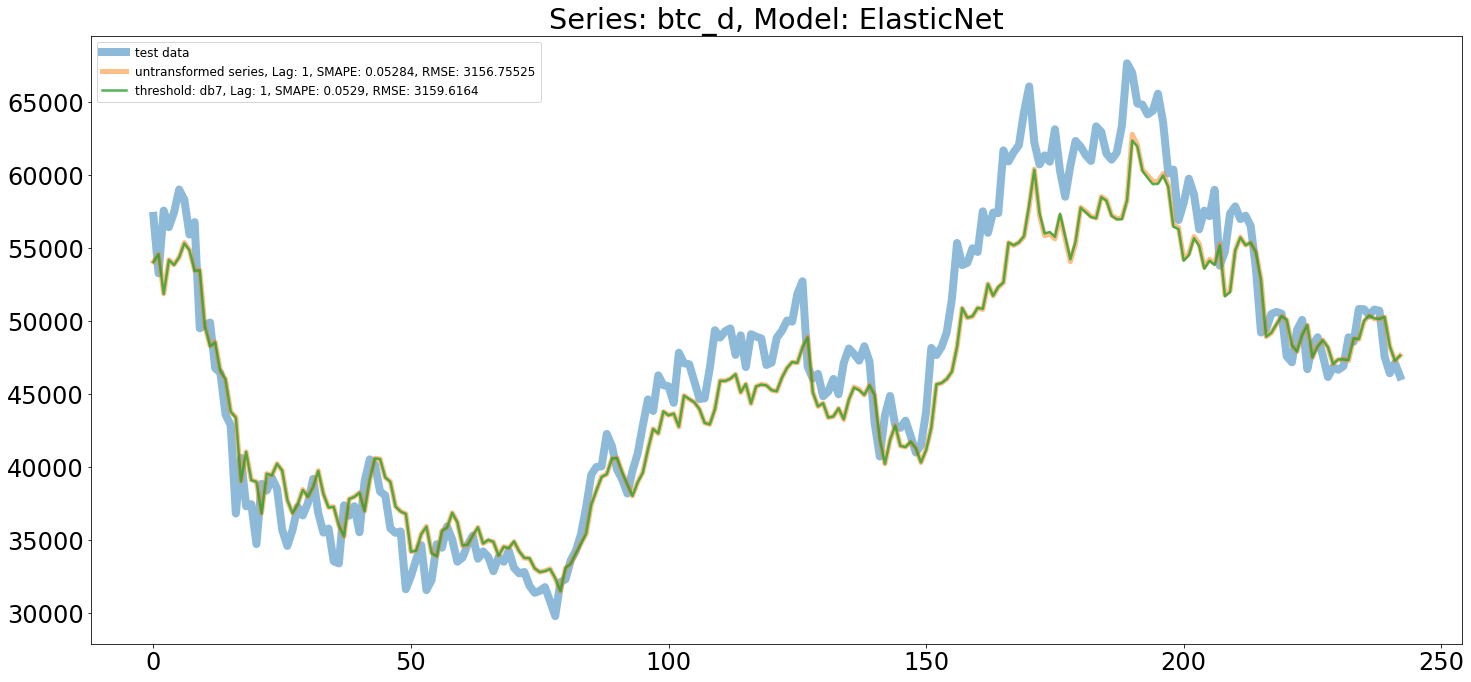

In [136]:
plot_prediction(datas, model='ElasticNet', only_test=True)

In [137]:
plot_log_prediction(datas, model='ElasticNet')

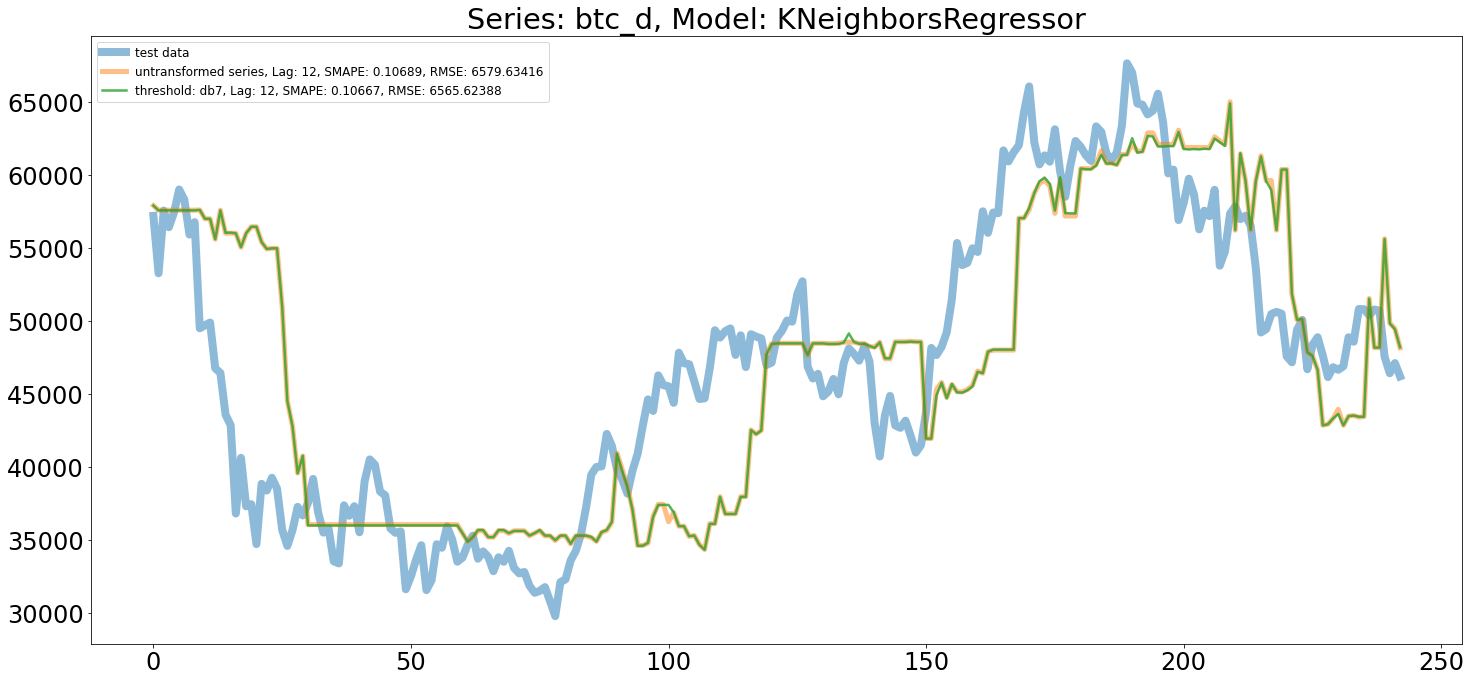

In [138]:
plot_prediction(datas, model='KNeighborsRegressor', only_test=True)

In [139]:
plot_log_prediction(datas, model='KNeighborsRegressor')

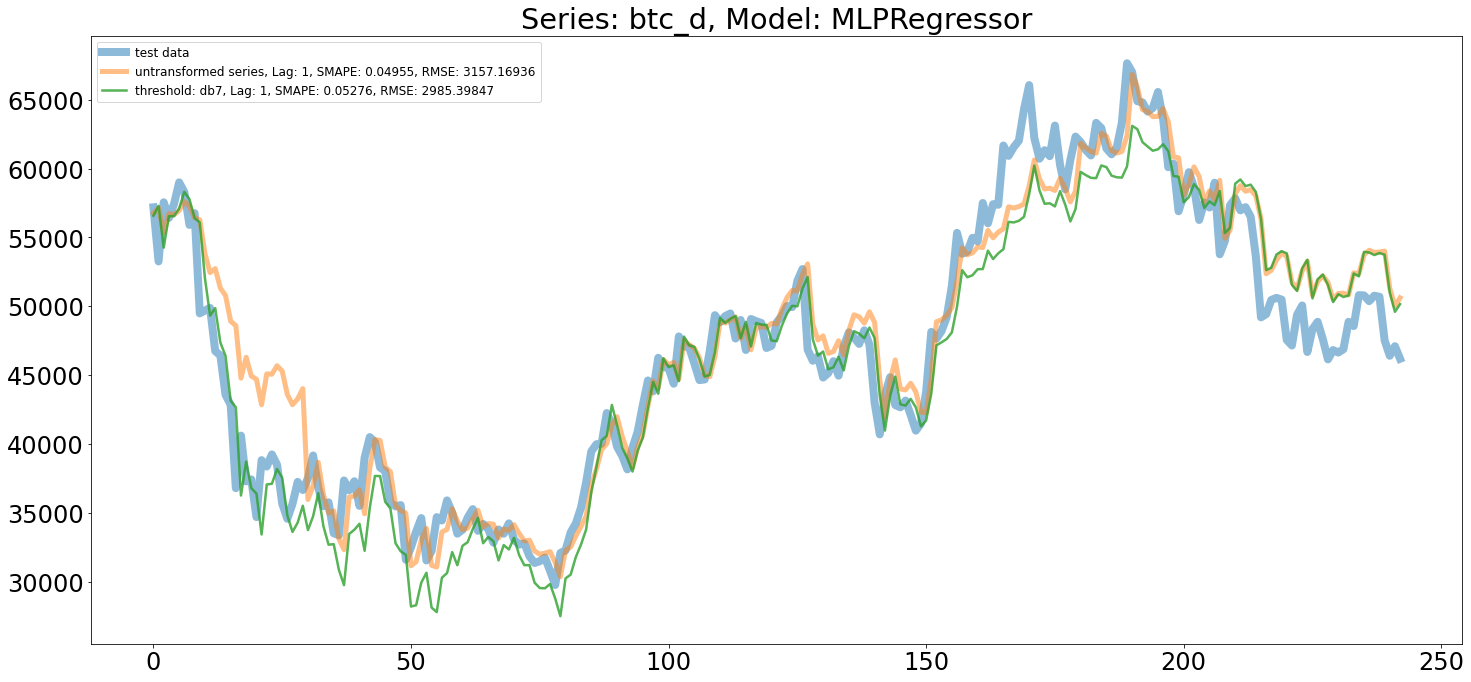

In [140]:
plot_prediction(datas, model='MLPRegressor', only_test=True)

In [141]:
plot_log_prediction(datas, model='MLPRegressor')

In [142]:
plot_prediction(datas, model='AutoETS', only_test=False)

In [143]:
plot_log_prediction(datas, model='AutoETS')

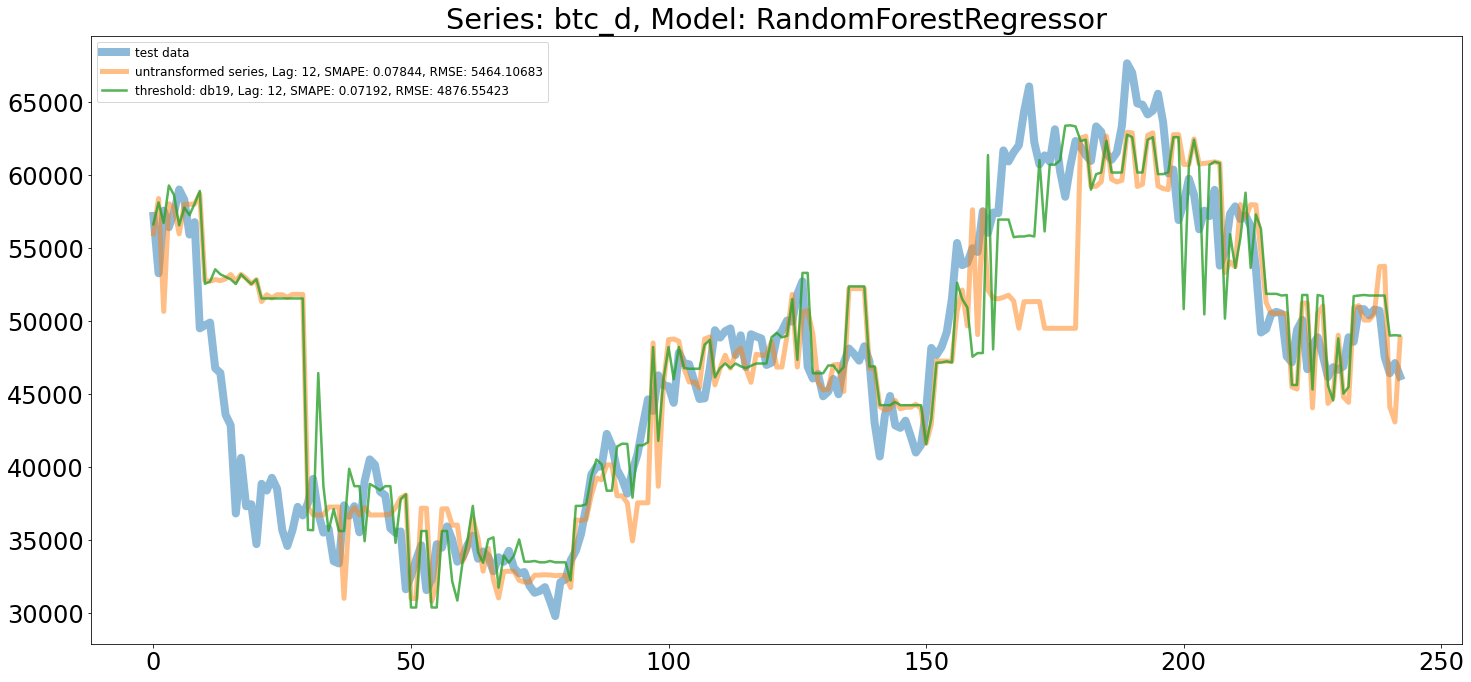

In [144]:
plot_prediction(datas, model='RandomForestRegressor', only_test=True)

In [145]:
plot_log_prediction(datas, model='RandomForestRegressor')

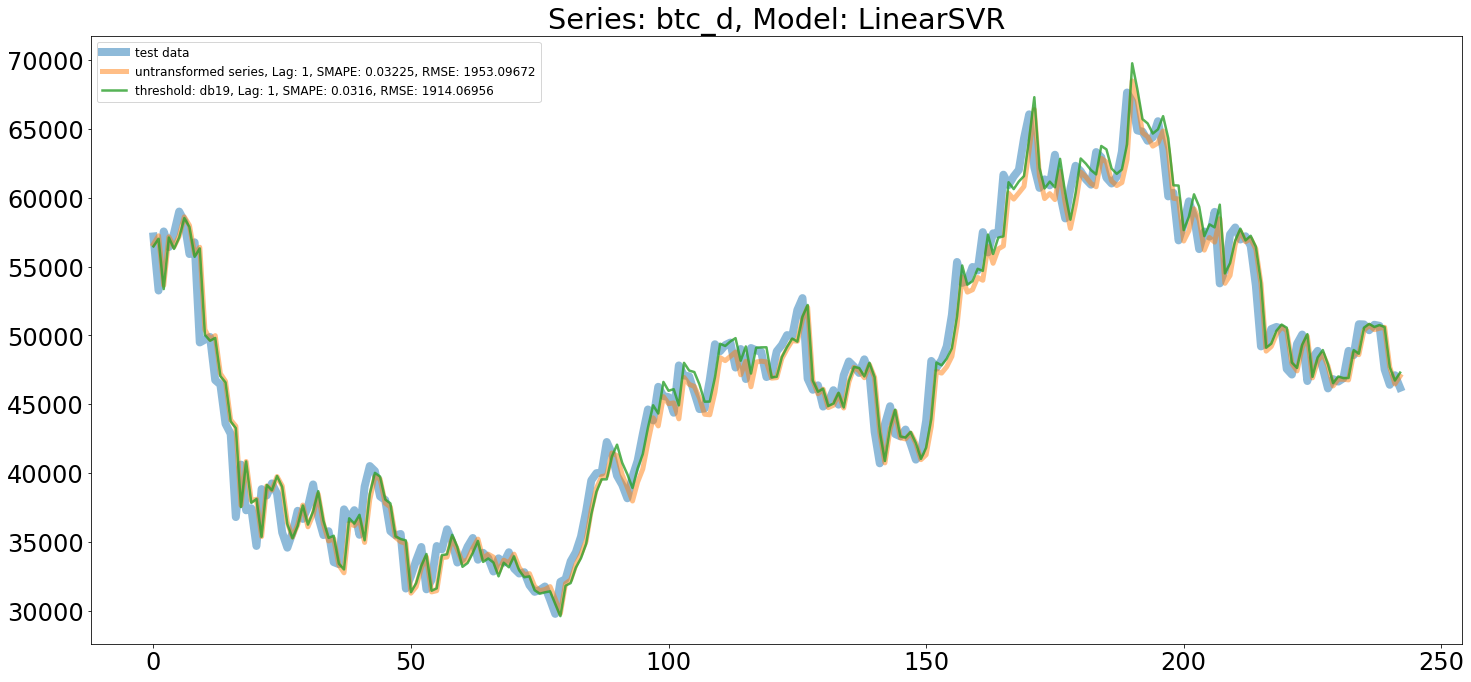

In [146]:
plot_prediction(datas, model='LinearSVR', only_test=True)

In [147]:
plot_log_prediction(datas, model='LinearSVR')

In [148]:
plot_prediction(datas, model='LSTM')

In [149]:
plot_log_prediction(datas, model='LSTM')

In [150]:
plot_prediction(datas, model='NaiveForecaster', only_test=False)

In [151]:
plot_log_prediction(datas, model='NaiveForecaster')

In [152]:


# smape_df.columns = [f'{m}({t[0]})' for m, t in smape_df.columns]
print([f'{m}({t[0]})' for m, t in smape_df.columns])
smape_df.columns = ['EN(u)', 'EN(t)', 'SVR(u)', 'SVR(t)', 'KNN(u)', 'KNN(t)', 'RF(u)', 'RF(t)', 'MLP(u)', 'MLP(t)', 'ETS(u)', 'ETS(t)', 'Naive(u)', 'Naive(t)']
# smape_df.columns = ['GRU(u)', 'GRU(t)', 'ETS(u)', 'ETS(t)', 'Naive(u)', 'Naive(t)']
# smape_df.columns = ['EN(u)', 'EN(t)', 'MLP(u)', 'MLP(t)', 'GRU(u)', 'GRU(t)', 'ETS(u)', 'ETS(t)']
smape_df.iloc[:-1,].boxplot(grid=False, showfliers=False, showmeans=True, rot=80, medianprops=dict(linewidth=2.5), capprops=dict(linewidth=2.5))
plt.ylabel('sMAPE')

['ElasticNet(u)', 'ElasticNet(t)', 'LinearSVR(u)', 'LinearSVR(t)', 'KNeighborsRegressor(u)', 'KNeighborsRegressor(t)', 'RandomForestRegressor(u)', 'RandomForestRegressor(t)', 'MLPRegressor(u)', 'MLPRegressor(t)']


ValueError: Length mismatch: Expected axis has 10 elements, new values have 14 elements